# Model training

In [380]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import PredefinedSplit

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import make_pipeline as imb_make_pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

In [423]:
df_final = pd.read_csv("data_for_model.csv")
data = df_final.drop(columns=["Unnamed: 0", "CAMIS"])
df_final.head()

,Unnamed: 0,CAMIS,ZIPCODE,CUISINE DESCRIPTION,GRADE,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,...,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
0,0,30112340,2.801389,2.913240,3.0,0.226460,4.392523,0.0,1.0,0.0,...,0.0,0.0,2501.0,12.2,63.2,18.4,2.4,1.6,35028.0,11.5
1,1,30112340,2.801389,2.913240,2.0,0.226460,4.392523,0.0,1.0,0.0,...,0.0,0.0,2501.0,12.2,63.2,18.4,2.4,1.6,35028.0,11.5
2,2,30191841,2.831125,2.814634,3.0,0.004614,1.120030,0.0,0.0,1.0,...,0.0,0.0,5195.0,72.9,3.6,8.4,0.0,12.3,141678.0,4.7
3,3,30191841,2.831125,2.814634,3.0,0.004614,1.120030,0.0,0.0,1.0,...,0.0,0.0,5195.0,72.9,3.6,8.4,0.0,12.3,141678.0,4.7
4,4,40356018,2.868895,2.834724,3.0,0.315359,9.367778,0.0,1.0,0.0,...,0.0,0.0,2185.0,38.0,2.2,40.8,0.0,19.1,20040.0,12.2


### Convert To Binary Problem

In [424]:
data.loc[data['GRADE'] == 1, 'GRADE'] = 1
data.loc[data['GRADE'] == 2, "GRADE"] = 1
data.loc[data['GRADE'] == 3, "GRADE"] = 0

In [425]:
# plt.hist(data.loc[data['GRADE'] == 1]["Asian"], color='red')
# plt.show()
# plt.hist(data.loc[data['GRADE'] == 0]["Asian"], color='green')
# plt.show()

# print("PASSING RESTAURANTS",data.loc[data['GRADE'] == 0]["Pop"].mean())

### Train Test Split and Scaling

In [426]:
dev, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["GRADE"])
train, val = train_test_split(dev, test_size = 0.2,  random_state=42)

dev_Y = dev["GRADE"].astype(int)
train_Y = train["GRADE"].astype(int)
val_Y = val["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(columns=["GRADE"])
train_X = train.drop(columns=["GRADE"])
val_X = val.drop(columns=["GRADE"])
test_X = test.drop(columns=["GRADE"])

# scaling numerical_data
scaler = StandardScaler()
dev_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(dev_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
train_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.fit_transform(train_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

val_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(val_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])
test_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]] = scaler.transform(test_X[["ClosestWorkingTankDis", "ClosestBadTankDis", "Pop", "White", "Hispanic", "Black", "Native", "Asian", "Inc", "Unemp"]])

dev_X.head()

,ZIPCODE,CUISINE DESCRIPTION,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,RESULT,Pop,White,Black,Hispanic,Native,Asian,Inc,Unemp
19196,2.876777,2.714226,0.011061,1.331296,1.0,0.0,0.0,0.0,0.0,1.0,-0.479976,-0.943447,-0.087544,1.908478,-0.264047,-0.933068,-0.857346,1.181238
15797,2.842294,2.834724,-0.358611,-0.208667,0.0,1.0,0.0,0.0,0.0,0.0,-1.202333,-0.323219,1.444511,-0.535207,-0.264047,-0.577255,-0.178274,0.356854
7215,2.731610,2.675366,0.014721,1.184310,1.0,0.0,0.0,0.0,0.0,0.0,0.083626,-1.478478,0.750376,1.934521,1.626343,-0.933068,-1.071807,1.425500
38359,2.604426,2.778831,-0.411364,0.743940,0.0,0.0,1.0,0.0,0.0,0.0,2.734736,-0.991157,-0.394946,2.294780,-0.264047,-0.752245,-0.913304,1.501832
21399,2.777661,2.804657,-0.483905,-0.776142,0.0,0.0,1.0,0.0,0.0,0.0,0.528068,1.540871,-0.627977,-0.791295,-0.264047,-0.810575,2.680585,-0.314866


### Baseline Model

ROC AUC from constant prediction model:  0.5
Average Precision from constant prediction model:  0.4712860768458951


<AxesSubplot:>

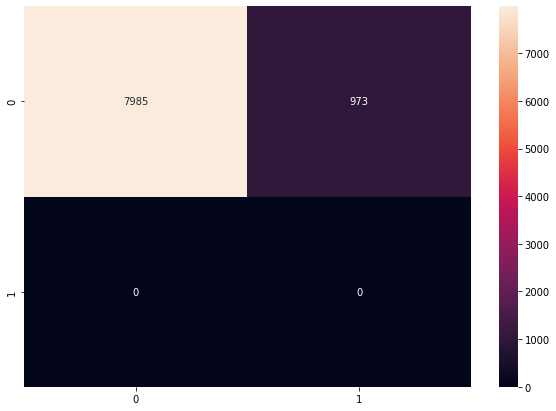

In [427]:
# Baseline model -- would just predict 3 everytime
constant_pred = np.repeat(0, test.shape[0])
base_acc = accuracy_score(constant_pred, test_Y)
# base_roc_auc = roc_auc_score(constant_pred, test_Y)
print("ROC AUC from constant prediction model: ", roc_auc_score(test_Y, constant_pred))
print("Average Precision from constant prediction model: ", f1_score(test_Y, constant_pred, average="macro"))
base_conf = confusion_matrix(constant_pred, test_Y)
plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')

### ROS

In [389]:
# resampling or other feature engineering techniques
ros = RandomOverSampler()
train_ROS = ros.fit_resample(train_X, train_Y)
train_ROS_X = train_ROS[0]
train_ROS_Y = train_ROS[1]

dev_ROS = ros.fit_resample(dev_X, dev_Y)
dev_ROS_X = dev_ROS[0]
dev_ROS_Y = dev_ROS[1]


In [390]:
# resampling or other feature engineering techniques
sm = SMOTE()
train_SMOTE = sm.fit_resample(train_X, train_Y)
train_SMOTE_X = train_SMOTE[0]
train_SMOTE_Y = train_SMOTE[1]

dev_SMOTE = sm.fit_resample(dev_X, dev_Y)
dev_SMOTE_X = dev_SMOTE[0]
dev_SMOTE_Y = dev_SMOTE[1]


### Lets see how a baseline logistic regression model does on original and sampled data

In [391]:
# Original Data
scores = cross_validate(LogisticRegression(), dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6453984781274513
Mean AP from 5-fold CV:  0.17852588051239923


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [392]:
# SMOTE Data
scores = cross_validate(LogisticRegression(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6585823148833329
Mean AP from 5-fold CV:  0.6235234459839079


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [393]:
# Random Over Sampling
scores = cross_validate(LogisticRegression(), dev_ROS_X, dev_ROS_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV:  0.6475106011174941
Mean AP from 5-fold CV:  0.6317628560361946


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [394]:
# Undersampling
rus = RandomUnderSampler(replacement=False, random_state=42)
pipe = imb_make_pipeline(rus, LogisticRegression())
scores = cross_validate(pipe, dev_X, dev_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV (Random Undersampling): ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: (Random Undersampling)", scores['test_average_precision'].mean())

/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

Mean AUC from 5-fold CV (Random Undersampling):  0.6437257416113293
Mean AP from 5-fold CV: (Random Undersampling) 0.17764460914303376


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [429]:
scores = cross_validate(RandomForestClassifier(), dev_ROS_X, dev_ROS_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())


Mean AUC from 5-fold CV:  0.9240873434900909
Mean AP from 5-fold CV:  0.8707854874984241


In [396]:
scores = cross_validate(XGBClassifier(), dev_SMOTE_X, dev_SMOTE_Y, cv=5, scoring=['roc_auc', 'average_precision'])
print("Mean AUC from 5-fold CV: ", scores['test_roc_auc'].mean())
print("Mean AP from 5-fold CV: ", scores['test_average_precision'].mean())

Mean AUC from 5-fold CV:  0.9465931759804078
Mean AP from 5-fold CV:  0.9545911313807508


It must be noted that in all of these metrics, we are performing training and validation on datasets that have already been resampled. We wanted to use this technique to simply illustrate why oversampling with XGBoost will likely yield the best ROC AUC, yet we understand that this metric is not entirely useful unless it is calculated on the test set. We expect a significant dropoff when done on the test set due to it being imbalanced and different.

In [428]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,400,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4)
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_ROS_X, dev_ROS_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.24961115773187736, max_depth=9, n_estimators=172;, score=0.920 total time=   4.3s
[CV 2/5] END learning_rate=0.24961115773187736, max_depth=9, n_estimators=172;, score=0.920 total time=   4.2s
[CV 3/5] END learning_rate=0.24961115773187736, max_depth=9, n_estimators=172;, score=0.922 total time=   4.2s
[CV 4/5] END learning_rate=0.24961115773187736, max_depth=9, n_estimators=172;, score=0.918 total time=   4.3s
[CV 5/5] END learning_rate=0.24961115773187736, max_depth=9, n_estimators=172;, score=0.922 total time=   4.2s
[CV 1/5] END learning_rate=0.11551973554406157, max_depth=9, n_estimators=116;, score=0.890 total time=   2.9s
[CV 2/5] END learning_rate=0.11551973554406157, max_depth=9, n_estimators=116;, score=0.894 total time=   3.0s
[CV 3/5] END learning_rate=0.11551973554406157, max_depth=9, n_estimators=116;, score=0.894 total time=   2.9s
[CV 4/5] END learning_rate=0.11551973554406157, max

In [415]:
optimal_SMOTE_xg = XGBClassifier(n_estimators =327, max_depth=9, learning_rate=0.23)
optimal_SMOTE_xg.fit(dev_X, dev_SMOTE_Y)
optimal_SMOTE_xg_preds = optimal_SMOTE_xg.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, optimal_SMOTE_xg_preds))
print("Tuned Final model has AP value of: ", average_precision_score(test_Y, optimal_SMOTE_xg_preds))

Tuned Final model has ROC AUC value of:  0.5754911090360202
Tuned Final model has AP value of:  0.13436205959076478


Final Model's confusion matrix:
XGBoost SMOTE Conf. Matrix


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


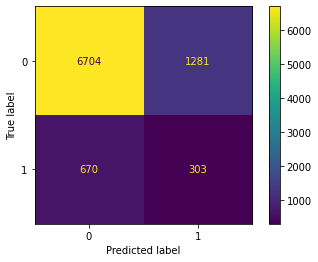

In [416]:
print("Final Model's confusion matrix:")
print("XGBoost SMOTE Conf. Matrix")
plot_confusion_matrix(optimal_SMOTE_xg, test_X, test_Y)

Feature Importance for XGBoost with Smote


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

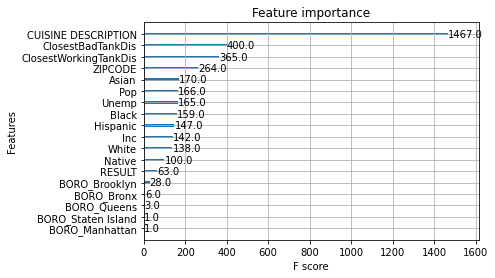

In [417]:
print("Feature Importance for XGBoost with Smote")
plot_importance(optimal_SMOTE_xg)

In [418]:
xg_pred_proba = optimal_SMOTE_xg.predict_proba(test_X)[:, 1]
model_1_fpr, model_1_tpr, _ = roc_curve(test_Y, xg_pred_proba, pos_label=1)
model_1_prec, model_1_recall, _ = precision_recall_curve(test_Y, xg_pred_proba)

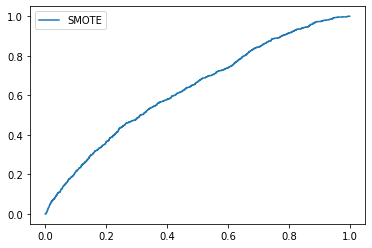

In [420]:
plt.plot(model_1_fpr, model_1_tpr, label="SMOTE")
plt.legend()
plt.show()

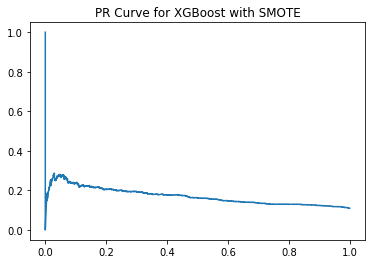

In [421]:
plt.title("PR Curve for XGBoost with SMOTE")
plt.plot(model_1_recall, model_1_prec, label="No Sampling")


Now lets see if using class weights can improve the situation...

In [438]:
xg_boost_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

xg_boost_grid_params = {'n_estimators': np.random.randint(100,600,4), 
                        'max_depth': np.random.randint(1,10,3), 
                        "learning_rate": np.random.uniform(0.01, 0.3, 4),
                        "scale_pos_weight": [99]
}

# # Fit the random search model
grid = RandomizedSearchCV(estimator=xg_boost_model, param_distributions=xg_boost_grid_params, cv=5, scoring="roc_auc", verbose=5, n_iter=10)
grid.fit(dev_X, dev_Y)
print(f" Using a random search, the optimal parameters for the XG Boost Tree with Class Weights were found to be {grid.best_params_}, with a top val score of {grid.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=0.15703271731413385, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.639 total time=   0.7s
[CV 2/5] END learning_rate=0.15703271731413385, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.653 total time=   1.4s
[CV 3/5] END learning_rate=0.15703271731413385, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.637 total time=   0.8s
[CV 4/5] END learning_rate=0.15703271731413385, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.650 total time=   0.5s
[CV 5/5] END learning_rate=0.15703271731413385, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.631 total time=   0.6s
[CV 1/5] END learning_rate=0.2082494397909067, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.634 total time=   0.5s
[CV 2/5] END learning_rate=0.2082494397909067, max_depth=2, n_estimators=148, scale_pos_weight=99;, score=0.653 total time=   0.5s
[CV 3/5] END lear

In [444]:
optimal_weighted_xg = XGBClassifier(n_estimators =412, max_depth=8, learning_rate=0.22, scale_pos_weight=99)
optimal_weighted_xg.fit(dev_X, dev_Y)
optimal_weighted_xg_preds = optimal_weighted_xg.predict(test_X)

print("Tuned Final model has ROC AUC value of: ", roc_auc_score(test_Y, optimal_weighted_xg_preds))
print("Tuned Final model has AP value of: ", average_precision_score(test_Y, optimal_weighted_xg_preds))

Tuned Final model has ROC AUC value of:  0.6042652558336192
Tuned Final model has AP value of:  0.13561884755525555


Final Model's confusion matrix:
XGBoost Weighted Conf. Matrix


/Users/elijahflomen/miniforge3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


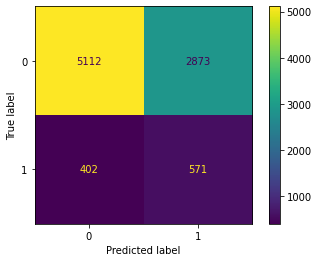

In [413]:
print("Final Model's confusion matrix:")
print("XGBoost Weighted Conf. Matrix")
plot_confusion_matrix(optimal_weighted_xg, test_X, test_Y)

Feature Importance for XGBoost with weights


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

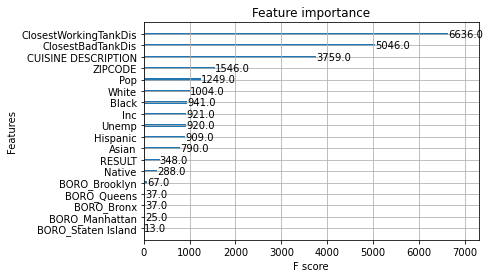

In [422]:
print("Feature Importance for XGBoost with weights")
plot_importance(optimal_weighted_xg)